In [1]:
from faster_rcnn.faster_rcnn_model import fasterrcnn_resnet50_fpn

In [2]:
## Simple Model
model = fasterrcnn_resnet50_fpn(pretrained = False, pretrained_backbone=False)

# ====== For finetuning, make changes to num_classes as ====== #
# # load a model pre-trained pre-trained on COCO
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
# # get number of input features for the classifier
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# # replace the pre-trained head with a new one
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

In [3]:
import torch
import os
import cv2
import numpy as np
# To parse our XML file containing annotations
from xml.etree import ElementTree as et

In [4]:
# defining the files directory and testing directory
files_dir = '/home/robin_unix/Company/Projects/deep_table_vision/datasets/train_zip/train'
test_dir = '/home/robin_unix/Company/Projects/deep_table_vision/datasets/test_zip/test'

class FruitImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg']
        
        
        # classes: 0 index is reserved for background
        self.classes = [_, 'apple','banana','orange']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res.transpose(2,0,1) , target

    def __len__(self):
        return len(self.imgs)
    
# check dataset
dataset = FruitImagesDataset(files_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[78]
print(img.shape, '\n',target)

length of dataset =  240 

(3, 224, 224) 
 {'boxes': tensor([[ 22.4000,  36.4903, 163.1000,  68.6452],
        [ 24.8500,  39.3806, 163.4500,  94.2968],
        [ 28.0000,  52.3871, 166.9500, 127.8968],
        [ 71.0500,  59.6129, 193.9000, 157.5226]]), 'labels': tensor([2, 2, 2, 2]), 'area': tensor([ 4524.1865,  7611.3750, 10492.0693, 12028.2041]), 'iscrowd': tensor([0, 0, 0, 0]), 'image_id': tensor([78])}


In [5]:
# use our dataset and defined transformations
dataset = FruitImagesDataset(files_dir, 224, 223)
dataset_test = FruitImagesDataset(files_dir, 480, 480)

In [6]:
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

## Inputs to Model

In [7]:
device = 'cpu'
for images, targets in data_loader:
    test_images = list(torch.from_numpy(image).to(device) for image in images)
    test_targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    break

In [8]:
## Final output
model.train()
test_out_train = model(test_images, test_targets)

/home/robin_unix/Company/Projects/rent_rolls_experiment/cascadetabnet-trainer/.tabnet/lib/python3.8/site-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


In [9]:
# model.eval()
# test_out_eval = model(test_images)

In [10]:
test_out_train.keys()

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])

## EXTRAS

## Transformation

In [11]:
import math
from torch.jit.annotations import List, Tuple, Dict, Optional
from faster_rcnn.image_list import ImageList
from torch import nn


def _resize_image_and_masks(image, self_min_size, self_max_size, target):
    # type: (Tensor, float, float, Optional[Dict[str, Tensor]]) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]
    im_shape = torch.tensor(image.shape[-2:])
    min_size = float(torch.min(im_shape))
    max_size = float(torch.max(im_shape))
    scale_factor = self_min_size / min_size
    if max_size * scale_factor > self_max_size:
        scale_factor = self_max_size / max_size
    image = torch.nn.functional.interpolate(
        image[None], scale_factor=scale_factor, mode='bilinear', recompute_scale_factor=True,
        align_corners=False)[0]

    if target is None:
        return image, target

    if "masks" in target:
        mask = target["masks"]
        mask = F.interpolate(mask[:, None].float(), scale_factor=scale_factor)[:, 0].byte()
        target["masks"] = mask
    return image, target

def resize_boxes(boxes, original_size, new_size):
    # type: (Tensor, List[int], List[int]) -> Tensor
    ratios = [
        torch.tensor(s, dtype=torch.float32, device=boxes.device) /
        torch.tensor(s_orig, dtype=torch.float32, device=boxes.device)
        for s, s_orig in zip(new_size, original_size)
    ]
    ratio_height, ratio_width = ratios
    xmin, ymin, xmax, ymax = boxes.unbind(1)

    xmin = xmin * ratio_width
    xmax = xmax * ratio_width
    ymin = ymin * ratio_height
    ymax = ymax * ratio_height
    return torch.stack((xmin, ymin, xmax, ymax), dim=1)

class GeneralizedRCNNTransform(nn.Module):
    def __init__(self, min_size=800, max_size=1300, image_mean=[0.485, 0.456, 0.406], image_std=[0.229, 0.224, 0.225]):
        super(GeneralizedRCNNTransform, self).__init__()
        if not isinstance(min_size, (list, tuple)):
            min_size = (min_size,)
        self.min_size = min_size
        self.max_size = max_size
        self.image_mean = image_mean
        self.image_std = image_std

    def forward(self,
                images,       # type: List[Tensor]
                targets=None  # type: Optional[List[Dict[str, Tensor]]]
                ):
        images = [img for img in images]
        if targets is not None:

            # targets = [{k: v for k,v in t.items()} for t in targets]
            targets_copy: List[Dict[str, Tensor]] = []
            for t in targets:
                data: Dict[str, Tensor] = {}
                for k, v in t.items():
                    data[k] = v
                targets_copy.append(data)
            targets = targets_copy
        for i in range(len(images)):
            image = images[i]
            target_index = targets[i] if targets is not None else None

            if image.dim() != 3:
                raise ValueError("images is expected to be a list of 3d tensors "
                                 "of shape [C, H, W], got {}".format(image.shape))
            image = self.normalize(image)
            image, target_index = self.resize(image, target_index)
            images[i] = image
            if targets is not None and target_index is not None:
                targets[i] = target_index

        image_sizes = [img.shape[-2:] for img in images]
        images = self.batch_images(images)
        image_sizes_list = torch.jit.annotate(List[Tuple[int, int]], [])
        for image_size in image_sizes:
            assert len(image_size) == 2
            image_sizes_list.append((image_size[0], image_size[1]))

        image_list = ImageList(images, image_sizes_list)
        return image_list, targets

    def normalize(self, image):
        dtype, device = image.dtype, image.device
        mean = torch.as_tensor(self.image_mean, dtype=dtype, device=device)
        std = torch.as_tensor(self.image_std, dtype=dtype, device=device)
        return (image - mean[:, None, None]) / std[:, None, None]

    def torch_choice(self, k):
        # type: (List[int]) -> int
        """
        Implements `random.choice` via torch ops so it can be compiled with
        TorchScript. Remove if https://github.com/pytorch/pytorch/issues/25803
        is fixed.
        """
        index = int(torch.empty(1).uniform_(0., float(len(k))).item())
        return k[index]

    def resize(self, image, target):
        # type: (Tensor, Optional[Dict[str, Tensor]]) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]
        h, w = image.shape[-2:]
        if self.training:
            size = float(self.torch_choice(self.min_size))
        else:
            # FIXME assume for now that testing uses the largest scale
            size = float(self.min_size[-1])
        
        image, target = _resize_image_and_masks(image, size, float(self.max_size), target)

        if target is None:
            return image, target

        bbox = target["boxes"]
        bbox = resize_boxes(bbox, (h, w), image.shape[-2:])
        target["boxes"] = bbox

        if "keypoints" in target:
            keypoints = target["keypoints"]
            keypoints = resize_keypoints(keypoints, (h, w), image.shape[-2:])
            target["keypoints"] = keypoints
        return image, target

    def max_by_axis(self, the_list):
        # type: (List[List[int]]) -> List[int]
        maxes = the_list[0]
        for sublist in the_list[1:]:
            for index, item in enumerate(sublist):
                maxes[index] = max(maxes[index], item)
        return maxes

    def batch_images(self, images, size_divisible=32):
        # type: (List[Tensor], int) -> Tensor
        max_size = self.max_by_axis([list(img.shape) for img in images])
        stride = float(size_divisible)
        max_size = list(max_size)
        max_size[1] = int(math.ceil(float(max_size[1]) / stride) * stride)
        max_size[2] = int(math.ceil(float(max_size[2]) / stride) * stride)

        batch_shape = [len(images)] + max_size
        batched_imgs = images[0].new_full(batch_shape, 0)
        for img, pad_img in zip(images, batched_imgs):
            pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)

        return batched_imgs

    def postprocess(self,
                    result,               # type: List[Dict[str, Tensor]]
                    image_shapes,         # type: List[Tuple[int, int]]
                    original_image_sizes  # type: List[Tuple[int, int]]
                    ):
        if self.training:
            return result
        for i, (pred, im_s, o_im_s) in enumerate(zip(result, image_shapes, original_image_sizes)):
            boxes = pred["boxes"]
            boxes = resize_boxes(boxes, im_s, o_im_s)
            result[i]["boxes"] = boxes
            if "masks" in pred:
                masks = pred["masks"]
                masks = paste_masks_in_image(masks, boxes, o_im_s)
                result[i]["masks"] = masks
            if "keypoints" in pred:
                keypoints = pred["keypoints"]
                keypoints = resize_keypoints(keypoints, im_s, o_im_s)
                result[i]["keypoints"] = keypoints
        return result
    
    
transform_net = GeneralizedRCNNTransform()

In [12]:
## No Trainable Parameters
for p in transform_net.parameters():
    print(p)

## Output after Transformation that goes into Backbone

In [13]:
trans_imgs, trans_targets = transform_net(test_images, test_targets)

In [14]:
test_images[0].shape, trans_targets

(torch.Size([3, 223, 224]),
 [{'boxes': tensor([[120.4500, 162.4521, 674.5200, 800.0000]]),
   'labels': tensor([1]),
   'area': tensor([27467.8574]),
   'iscrowd': tensor([0]),
   'image_id': tensor([47])},
  {'boxes': tensor([[188.2031, 252.0548, 676.4857, 682.5832],
           [198.6589, 156.5558, 651.3919, 516.6340]]),
   'labels': tensor([2, 2]),
   'area': tensor([16346.3330, 12676.1240]),
   'iscrowd': tensor([0, 0]),
   'image_id': tensor([94])}])

## Enter the Backbone

In [15]:
## Goes through backbone + FPN
features = model.backbone(trans_imgs.tensors)

In [16]:
for k, v in features.items():
    print(f'{k} --> ', v.shape)

0 -->  torch.Size([2, 256, 200, 208])
1 -->  torch.Size([2, 256, 100, 104])
2 -->  torch.Size([2, 256, 50, 52])
3 -->  torch.Size([2, 256, 25, 26])
pool -->  torch.Size([2, 256, 13, 13])


## Enter RPN

In [298]:
from faster_rcnn.rpn import RegionProposalNetwork, RPNHead, AnchorGenerator

anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
out_channels = 256
## DEFINE GENERATOR ##
rpn_anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)

## DEFINE RPN HEAD
rpn_head = RPNHead(
                out_channels, rpn_anchor_generator.num_anchors_per_location()[0]
            )
rpn_pre_nms_top_n_train=2000
rpn_pre_nms_top_n_test=1000
rpn_post_nms_top_n_train=2000
rpn_post_nms_top_n_test=1000
rpn_nms_thresh=0.7
rpn_fg_iou_thresh=0.7
rpn_bg_iou_thresh=0.3
rpn_batch_size_per_image=256
rpn_positive_fraction=0.5

rpn_pre_nms_top_n = dict(
            training=rpn_pre_nms_top_n_train, testing=rpn_pre_nms_top_n_test
        )

rpn_post_nms_top_n = dict(
            training=rpn_post_nms_top_n_train, testing=rpn_post_nms_top_n_test
        )

rpn = RegionProposalNetwork(
            rpn_anchor_generator,
            rpn_head,
            rpn_fg_iou_thresh,
            rpn_bg_iou_thresh,
            rpn_batch_size_per_image,
            rpn_positive_fraction,
            rpn_pre_nms_top_n,
            rpn_post_nms_top_n,
            rpn_nms_thresh,
        )

In [299]:
proposals, proposal_losses = rpn(trans_imgs, features, trans_targets)

In [300]:
proposals[0].shape, proposals[1].shape

(torch.Size([2000, 4]), torch.Size([2000, 4]))

# Checking RPN Head INdependtly

In [316]:
## Checking rpn_head separarely
objectness, pred_bbox_deltas = rpn_head( list(features.values()) )

In [317]:
len(objectness), len(pred_bbox_deltas)

(5, 5)

In [318]:
## Output of Logits
## Convert 256 channel output > Num_of_anchors channel output
for i in range(len(objectness)):
    print( rpn_head_out[0][i].shape )

torch.Size([2, 3, 200, 208])
torch.Size([2, 3, 100, 104])
torch.Size([2, 3, 50, 52])
torch.Size([2, 3, 25, 26])
torch.Size([2, 3, 13, 13])


In [322]:
num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
num_anchors_per_level = [
            s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors
        ]

num_anchors_per_level

[124800, 31200, 7800, 1950, 507]

In [319]:
## Output of Regressoion
## Convert 256 channel output > "Num_of_anchors * 3" channel output
for i in range(len(pred_bbox_deltas)):
    print( rpn_head_out[1][i].shape )

torch.Size([2, 12, 200, 208])
torch.Size([2, 12, 100, 104])
torch.Size([2, 12, 50, 52])
torch.Size([2, 12, 25, 26])
torch.Size([2, 12, 13, 13])


# Understanding Anchor Generator
- We employ Features-maps from FPN to dynamically generate anchor boxes
- For all that we care, We could hard code positions where we could generate anchor boxes as well. But they did the experiment and it worked. Maybe we can experiment with a hard-coded anchor generator and figure out the difference.

- First layer feature map : `200* 208` generates `208 * 208 * 3` anchor boxes of Size 32
- Second layer feature map : `100 * 104` generates `100 * 104 * 3` anchor boxes of Size 64
- Similarly, Last layer feature map : `13 * 13` generates `13 * 13 * 3` anchor boxes of Size 512 .. 
- Thus this allows to generated large number of small anchor boxes and smaller number of large anchor boxes. 

In [68]:
anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)

rpn_anchor_generator.generate_anchors( scales = ((32,)), aspect_ratios=((0.5,1,2)) )

tensor([[-23., -11.,  23.,  11.],
        [-16., -16.,  16.,  16.],
        [-11., -23.,  11.,  23.]])

### Observations on Anchor Generator :
- NOTE : the code assumption is `ASPECT_RATIO = Height / Width` !
- In this code, we are generating 3 anchor boxes for a image of size 32.
      ```rpn_anchor_generator.generate_anchors( scales = ((32,)), aspect_ratios=((0.5,1,2)) )```
- First anchor bbox is :  `[x0= -23., y0=-11.,  x1=23.,  y1=11.]` . As `aspect_ratio = 0.5` i.e width is twice the height. We can see that Anchor box has `WIDTH=46` and `HEIGHT=22` Centered around zero origin.

In [234]:
for k, v in features.items():
    print(f'Feature Layer : {k} , feature size is : {v.shape[2:]}')

Feature Layer : 0 , feature size is : torch.Size([200, 208])
Feature Layer : 1 , feature size is : torch.Size([100, 104])
Feature Layer : 2 , feature size is : torch.Size([50, 52])
Feature Layer : 3 , feature size is : torch.Size([25, 26])
Feature Layer : pool , feature size is : torch.Size([13, 13])


In [235]:
## At each point of the Feature Map, we draw 3 anchors 
## This, Total Anchor Boxe Generated is :
(200 * 208 * 3) + (100 * 104 * 3) + (50*52*3) + (25*26*3) + (13*13*3)

166257

In [289]:
## Output is list of anchors per image.
# each element of list is : Tensor of shape >> [ Num_anchors , 4 ]
anchors = rpn_anchor_generator(trans_imgs, list(features.values()))

# NOTE : Both anchors are essentially the same
assert torch.all(anchors[0] == anchors[1])

(166257, 166257)

AssertionError: 

In [288]:
anchors[1][:5]

tensor([[-23., -11.,  23.,  11.],
        [-16., -16.,  16.,  16.],
        [-11., -23.,  11.,  23.],
        [-19., -11.,  27.,  11.],
        [-12., -16.,  20.,  16.]])

In [284]:
len(anchors)

2

In [262]:
## MOre
rpn_anchor_generator.cell_anchors = [
    rpn_anchor_generator.generate_anchors(sizes, aspect_ratios)
    for sizes, aspect_ratios in zip(anchor_sizes, aspect_ratios)
]

In [263]:
grid_sizes = list([feature_map.shape[-2:] for feature_map in list(features.values())])
# size of input image : [width, height]
image_size = trans_imgs.tensors.shape[-2:]
dtype, device = list(features.values())[0].dtype, list(features.values())[0].device
strides = [
    [
        torch.tensor(image_size[0] // g[0], dtype=torch.int64, device=device),
        torch.tensor(image_size[1] // g[1], dtype=torch.int64, device=device),
    ]
    for g in grid_sizes
]


In [264]:
grid_sizes

[torch.Size([200, 208]),
 torch.Size([100, 104]),
 torch.Size([50, 52]),
 torch.Size([25, 26]),
 torch.Size([13, 13])]

In [265]:
strides

[[tensor(4), tensor(4)],
 [tensor(8), tensor(8)],
 [tensor(16), tensor(16)],
 [tensor(32), tensor(32)],
 [tensor(61), tensor(64)]]

## NOTES :
- We use `FEATURE MAP : torch.Size([200, 208])` and `STRIDE : [tensor(4), tensor(4)]` and `Cell Anchor with 32 size for 3 aspect ratio`
Similarly .. continuing .. 
- We use `FEATURE MAP : torch.Size([13, 13])` and `STRIDE : [tensor(61), tensor(64)]` and `Cell Anchor with 512 size for 3 aspect ratio`

### Why ? 
- Because We draw 3 anchor boxes for each position in feature-map. Now, For 200*208 feature map, it makes sense to use smaller anchor boxes 

In [241]:
import matplotlib.pyplot as plt
%matplotlib inline

def adapt_bbox(bbox_tensor):
    """
    Utility function to map anchor bboxes to format  matplotlib understands 
    """
    bbox_tensor = bbox_tensor.numpy()
    x0, y0, x1, y1 = bbox_tensor
    x_top, y_top = x0, y1
    width = x1 - x0
    height = y1 - y0
    return x_top, y_top, width, height

In [242]:
img = trans_imgs.tensors[0][0,:,:]

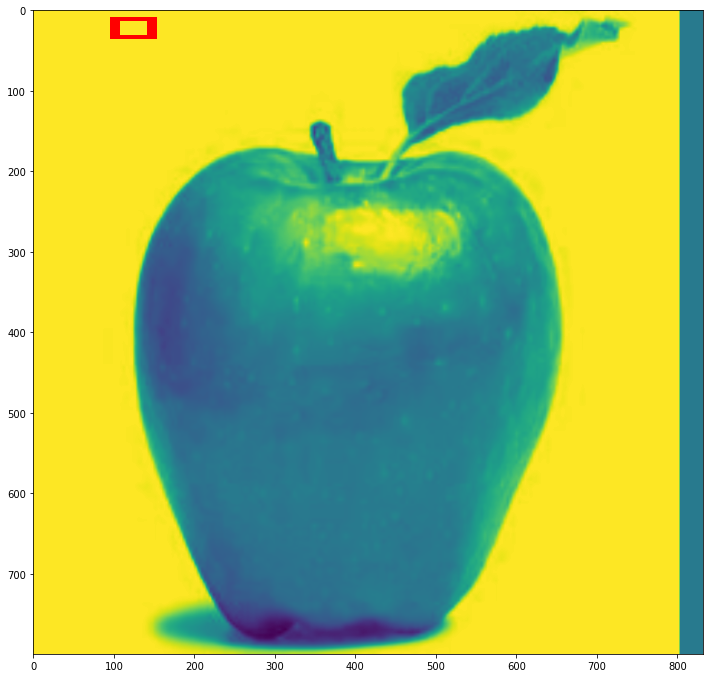

In [245]:

import matplotlib.patches as patches

# Create figure and axes
fig, ax = plt.subplots(figsize=(12,12))

# Display the image
ax.imshow(img)

# Show all Bbox generated per last feature maps 
for anchor_box in anchors[0][30:33]: 
    x_top, y_top, width, height = adapt_bbox(anchor_box)
    rect = patches.Rectangle((x_top, y_top), width, height, linewidth=4, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()

In [266]:
grid_sizes, strides

([torch.Size([200, 208]),
  torch.Size([100, 104]),
  torch.Size([50, 52]),
  torch.Size([25, 26]),
  torch.Size([13, 13])],
 [[tensor(4), tensor(4)],
  [tensor(8), tensor(8)],
  [tensor(16), tensor(16)],
  [tensor(32), tensor(32)],
  [tensor(61), tensor(64)]])

In [267]:
grid_height, grid_width = grid_sizes[0]
stride_height, stride_width = strides[0]
device = "cpu"

# For output anchor, compute [x_center, y_center, x_center, y_center]
shifts_x = (
    torch.arange(0, grid_width, dtype=torch.float32, device=device)
    * stride_width
)
shifts_y = (
    torch.arange(0, grid_height, dtype=torch.float32, device=device)
    * stride_height
)
shift_y, shift_x = torch.meshgrid(shifts_y, shifts_x)
# Reshape both to a single row
shift_x = shift_x.reshape(-1)
shift_y = shift_y.reshape(-1)
# columns of : shift_X, shift_y, shift_x, shift_y
shifts = torch.stack((shift_x, shift_y, shift_x, shift_y), dim=1)

# For every (base anchor, output anchor) pair,
# offset each zero-centered base anchor by the center of the output anchor.
# anchors.append(
#     (shifts.view(-1, 1, 4) + base_anchors.view(1, -1, 4)).reshape(-1, 4)
# )

In [276]:
shifts.view(-1, 1, 4).shape

torch.Size([41600, 1, 4])

In [277]:
rpn_anchor_generator.cell_anchors[0].view(1, -1, 4).shape

torch.Size([1, 3, 4])

In [279]:
( shifts.view(-1, 1, 4) + rpn_anchor_generator.cell_anchors[0].view(1, -1, 4) )[0]

tensor([[-23., -11.,  23.,  11.],
        [-16., -16.,  16.,  16.],
        [-11., -23.,  11.,  23.]])

## INSIDE RPN FORWARD PASS

In [347]:
from faster_rcnn.rpn import concat_box_prediction_layers 
objectness, pred_bbox_deltas = rpn_head(list(features.values()))
anchors = rpn_anchor_generator(trans_imgs, list(features.values()))

num_images = len(anchors)
num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
num_anchors_per_level = [
    s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors
]

# Just change the shape.
objectness, pred_bbox_deltas = concat_box_prediction_layers(
    objectness, pred_bbox_deltas
)

In [348]:
objectness

tensor([[-0.1528],
        [-0.0141],
        [ 0.0119],
        ...,
        [ 0.0142],
        [ 0.1184],
        [ 0.1745]], grad_fn=<ViewBackward>)